# Import libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

2024-06-07 12:28:04.682045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 12:28:04.682145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 12:28:04.813492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')

# Import dataset

In [3]:
google_training_complete = pd.read_csv("/kaggle/input/google-alphabet-inc-stock-prices-2018-2024/GOOG.csv")
google_training_complete.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,53.250000,24752000
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,54.124001,28604000
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,54.320000,20092000
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,55.111500,25582000
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,55.347000,20952000


In [4]:
google_training_processed = google_training_complete.iloc[:, 1:2].values
google_training_processed

array([[ 52.417   ],
       [ 53.2155  ],
       [ 54.400002],
       ...,
       [142.830002],
       [141.850006],
       [140.679993]])

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))
google_training_scaled = scaler.fit_transform(google_training_processed)

google_training_scaled.shape

(1509, 1)

In [6]:
features_set = []
labels = []

for i in range(60, google_training_scaled.shape[0]):
    features_set.append(google_training_scaled[i - 60:i, 0])
    labels.append(google_training_scaled[i, 0])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set.shape

(1449, 60)

**LSTM layers work on 3D data with the following structure (nb_sequence, nb_timestep, nb_feature).

    nb_sequence corresponds to the total number of sequences in your dataset (or to the batch size if you are using mini-batch learning).
    nb_timestep corresponds to the size of your sequences.
    nb_feature corresponds to number of features describing each of your timesteps.


In [7]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(1449, 60, 1)

# Training model

In [8]:
model = Sequential()

model.add(LSTM(units=300, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units=100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 300)        │       362,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,701 (2.61 MB)

 Trainable params: 683,701 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(features_set, labels, epochs = 300, batch_size = 32)

Epoch 1/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0738
Epoch 2/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047
Epoch 3/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047
Epoch 4/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041
Epoch 5/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0037
Epoch 6/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042
Epoch 7/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032
Epoch 8/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032
Epoch 9/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041
Epoch 10/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042
Epoch 11/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033
Epoch 12/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029
Epoch 13/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 14/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029
Epoch 15/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - lo

# Import test dataset to predict

In [11]:
google_testing_complete = pd.read_csv("/kaggle/input/google-alphabet-inc-stock-prices-2018-2024/GOOG-Jun-2024.csv")
google_testing_processed = google_testing_complete.iloc[:, 1:2].values

In [12]:
google_total = pd.concat((google_training_complete['Open'], google_testing_complete['Open']), axis=0)

test_inputs = google_total[len(google_total) - len(google_testing_complete) - 60:].values
test_inputs

array([136.130005, 134.940002, 137.990005, 139.509995, 139.850006,
       142.160004, 140.649994, 139.729996, 140.029999, 140.75    ,
       139.800003, 138.589996, 136.229996, 139.160004, 129.770004,
       124.470001, 124.029999, 124.459999, 126.269997, 125.339996,
       129.559998, 129.089996, 130.220001, 131.979996, 132.360001,
       133.360001, 131.529999, 133.360001, 135.649994, 136.639999,
       136.960007, 137.820007, 135.5     , 137.940002, 139.100006,
       139.539993, 137.570007, 137.630005, 138.985001, 136.399994,
       133.320007, 131.294006, 130.369995, 132.899994, 136.600006,
       135.660004, 133.820007, 133.270004, 134.544998, 134.770004,
       132.919998, 133.860001, 138.      , 140.330002, 140.770004,
       142.130005, 142.979996, 142.830002, 141.850006, 140.679993,
       139.600006, 138.600006, 139.850006, 138.352005, 138.      ,
       140.059998, 142.520004, 144.895004, 144.339996, 143.429993,
       142.910004, 143.440002, 146.304993, 148.710007, 147.720

In [13]:
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

In [14]:
test_features = []

for i in range(60, 81):
    test_features.append(test_inputs[i - 60:i, 0])

In [15]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [16]:
predictions = model.predict(test_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)

# Plot results

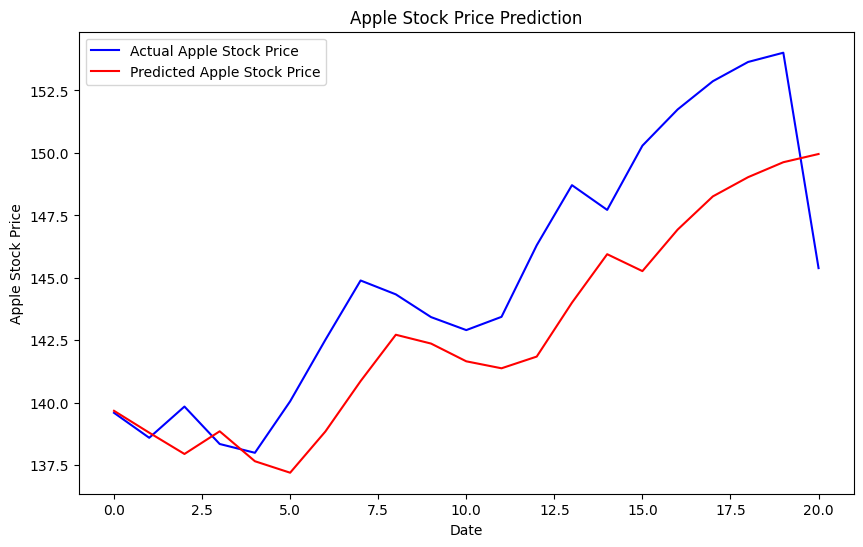

In [18]:
plt.figure(figsize=(10,6))
plt.plot(google_testing_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()